# **Waze Project - ML models**

Build a machine learning model to predict user churn. To get the best results, I will build and test two tree-based models: random forest and XGBoost.

- Waze asked to build a random forest and XGBoost models as the final stage of user churn project.
- It is important to have lower false negative rate because if Waze won't accurately predict the users that will actually churn, they miss the opportunity to prevent it. Cost of false positives will be less compared to false negatives.
- The benefits of the model might outweigh the potential problems but it is important for Waze to take preventetive actions without causing negative effects to users (such as loyal customers). Therefore observing results and follow up analysis are crucial.

In [1]:
# Import packages for data manipulation
### YOUR CODE HERE ###
import pandas as pd
import numpy as np

# Import packages for data visualization
### YOUR CODE HERE ###
import matplotlib.pyplot as plt

# This lets us see all of the columns, preventing Juptyer from redacting them.
### YOUR CODE HERE ###
pd.set_option('display.max_columns', None)

# Import packages for data modeling
### YOUR CODE HERE ###
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# This is the function that helps plot feature importance
from xgboost import plot_importance

# This module lets us save our models once we fit them.
import pickle

In [2]:
# Import dataset
df0 = pd.read_csv('waze_ml_ready')

In [3]:
# Inspect the first five rows
### YOUR CODE HERE ###
df0.head(10)

,Unnamed: 0,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device,km_per_driving_day,percent_sessions_in_last_month,professional_driver,label2,device2
0,0,retained,243,200,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android,138.360267,0.953670,1,0,0.0
1,1,retained,133,107,326.896596,1225,19,64,8889.794236,3160.472914,13,11,iPhone,1246.901868,0.406856,0,0,1.0
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android,382.393602,0.841186,0,0,0.0
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone,304.530374,0.724968,0,0,1.0
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android,219.455667,0.499266,1,0,0.0
5,5,retained,113,103,279.544437,2637,0,0,901.238699,439.101397,15,11,iPhone,81.930791,0.404229,0,0,1.0
6,6,retained,3,2,236.725314,360,185,18,5249.172828,726.577205,28,23,iPhone,228.224906,0.012673,0,0,1.0
7,7,retained,39,35,176.072845,2999,0,0,7892.052468,2466.981741,22,20,iPhone,394.602623,0.221499,0,0,1.0
8,8,retained,57,46,183.532018,424,0,26,2651.709764,1594.342984,25,20,Android,132.585488,0.310573,0,0,0.0
9,9,churned,84,68,244.802115,2997,72,0,6043.460295,2341.838528,7,3,iPhone,2014.486765,0.343134,0,1,1.0


In [4]:
# Copy the df0 dataframe
### YOUR CODE HERE ###
df = df0.copy()

In [5]:
### YOUR CODE HERE ###
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14299 entries, 0 to 14298
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unnamed: 0                      14299 non-null  int64  
 1   label                           14299 non-null  object 
 2   sessions                        14299 non-null  int64  
 3   drives                          14299 non-null  int64  
 4   total_sessions                  14299 non-null  float64
 5   n_days_after_onboarding         14299 non-null  int64  
 6   total_navigations_fav1          14299 non-null  int64  
 7   total_navigations_fav2          14299 non-null  int64  
 8   driven_km_drives                14299 non-null  float64
 9   duration_minutes_drives         14299 non-null  float64
 10  activity_days                   14299 non-null  int64  
 11  driving_days                    14299 non-null  int64  
 12  device                          

In [6]:
# Create `total_sessions_per_day` feature
df['total_sessions_per_day'] = df['total_sessions'] / df['n_days_after_onboarding']

In [7]:
# Get descriptive stats
df['total_sessions_per_day'].describe()

count    14299.000000
mean         0.329996
std          1.292124
min          0.000298
25%          0.050818
50%          0.100457
75%          0.208580
max         39.763874
Name: total_sessions_per_day, dtype: float64

#### **`km_per_hour`**

Create a column representing the mean kilometers per hour driven in the last month.

In [8]:
# Create `km_per_hour` feature
df['km_per_hour'] = df['driven_km_drives'] / (df['duration_minutes_drives'] / 60)

#### **`km_per_drive`**

Create a column representing the mean number of kilometers per drive made in the last month for each user. Then, print descriptive statistics for the feature.

In [9]:
# Create `km_per_drive` feature
df['km_per_drive'] = df['driven_km_drives'] / df['drives']
df['km_per_drive'].describe()

count    1.429900e+04
mean              inf
std               NaN
min      1.008775e+00
25%      3.365859e+01
50%      7.429025e+01
75%      1.828194e+02
max               inf
Name: km_per_drive, dtype: float64

This feature has infinite values too. Convert the infinite values to zero, then confirm that it worked.

In [10]:
# 1. Convert infinite values to zero
df.loc[df['km_per_drive'] == np.inf, 'km_per_drive'] = 0

# 2. Confirm that it worked
df['km_per_drive'].describe()

count    14299.000000
mean       225.797731
std        572.400481
min          0.000000
25%         32.910489
50%         72.319628
75%        177.431844
max       8889.794236
Name: km_per_drive, dtype: float64

#### **`percent_of_sessions_to_favorite`**

This is a proxy representation for the percent of overall drives that are to a favorite place. Since total drives since onboarding are not contained in this dataset, total sessions must serve as a reasonable approximation.

People whose drives to non-favorite places make up a higher percentage of their total drives might be less likely to churn, since they're making more drives to less familiar places.

In [11]:
# Create `percent_of_sessions_to_favorite` feature
df['percent_of_sessions_to_favorite'] = (df['total_navigations_fav1'] + df['total_navigations_fav2']) / df['total_sessions']

# Get descriptive stats
df['percent_of_sessions_to_favorite'].describe()

count    14299.000000
mean         1.575282
std          8.243636
min          0.000000
25%          0.212409
50%          0.648292
75%          1.593733
max        668.888397
Name: percent_of_sessions_to_favorite, dtype: float64

In [12]:
# Drop rows with missing values
df = df.dropna(subset=['label'])                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [13]:
df = df.drop(['Unnamed: 0'], axis=1)
df.head()

,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device,km_per_driving_day,percent_sessions_in_last_month,professional_driver,label2,device2,total_sessions_per_day,km_per_hour,km_per_drive,percent_of_sessions_to_favorite
0,retained,243,200,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android,138.360267,0.953670,1,0,0.0,0.130381,79.430298,13.144225,0.700931
1,retained,133,107,326.896596,1225,19,64,8889.794236,3160.472914,13,11,iPhone,1246.901868,0.406856,0,0,1.0,0.266854,168.768304,83.082189,0.253903
2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android,382.393602,0.841186,0,0,0.0,0.051121,113.953460,32.201567,0.000000
3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone,304.530374,0.724968,0,0,1.0,4.505948,93.351141,22.839778,4.867640
4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android,219.455667,0.499266,1,0,0.0,0.107713,194.342970,58.091206,1.016363


In [14]:
# Create new `device2` variable
df['device2'] = np.where(df['device']=='Android', 0, 1)
df[['device', 'device2']].tail()

,device,device2
14294,iPhone,1
14295,Android,0
14296,iPhone,1
14297,iPhone,1
14298,iPhone,1


In [15]:
# Create binary `label2` column
df['label2'] = np.where(df['label']=='retained', 0,1)

In [16]:
df[['label','label2']].tail()

,label,label2
14294,retained,0
14295,retained,0
14296,retained,0
14297,churned,1
14298,retained,0


In [17]:
# Get class balance of 'label' col
df['label'].value_counts(normalize=True)

retained    0.822645
churned     0.177355
Name: label, dtype: float64

Approximately 18% of the users in this dataset churned. This is an unbalanced dataset, but not extremely so. It can be modeled without any class rebalancing.

It was already determined that the risks involved in making a false positive prediction are minimal. No one stands to get hurt, lose money, or suffer any other significant consequence if they are predicted to churn. Therefore, select the model based on the recall score.

In [18]:
# 1. Isolate X variables
X = df.drop(columns=['label', 'label2', 'device'])

# 2. Isolate y variable
y = df['label2']

# 3. Split into train and test sets
X_tr, X_test, y_tr, y_test = train_test_split(X, y, stratify=y,
                                              test_size=0.2, random_state=42)

# 4. Split into train and validate sets
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, stratify=y_tr,
                                                  test_size=0.25, random_state=42)

In [19]:
print(len(X_train),len(X_val), len(X_test))

8579 2860 2860


This aligns with expectations.

### **Task 10. Modeling**

In [20]:
# 1. Instantiate the random forest classifier
rf = RandomForestClassifier(random_state=42)

# 2. Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [None],
             'max_features': [1.0],
             'max_samples': [1.0],
             'min_samples_leaf': [2],
             'min_samples_split': [2],
             'n_estimators': [200]
             }

# 3. Define a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# 4. Instantiate the GridSearchCV object
rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='recall')

In [21]:
rf_cv.fit(X_train,y_train)

GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None], 'max_features': [1.0],
                         'max_samples': [1.0], 'min_samples_leaf': [2],
                         'min_samples_split': [2], 'n_estimators': [200]},
             refit='recall', scoring={'f1', 'precision', 'accuracy', 'recall'})

Examine the best average score across all the validation folds.

In [22]:
# Examine best score
rf_cv.best_score_

0.11758184832159138

Examine the best combination of hyperparameters.

In [23]:
# Examine best hyperparameter combo
rf_cv.best_params_

{'max_depth': None,
 'max_features': 1.0,
 'max_samples': 1.0,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 200}

In [24]:
rf_cv.best_estimator_

RandomForestClassifier(max_features=1.0, max_samples=1.0, min_samples_leaf=2,
                       n_estimators=200, random_state=42)

Use the `make_results()` function to output all of the scores of your model. Note that the function accepts three arguments.

In [25]:
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
        model_name (string): what you want the model to be called in the output table
        model_object: a fit GridSearchCV object
        metric (string): precision, recall, f1, or accuracy

    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean 'metric' score across all validation folds.
    '''

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy',
                   }

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    # Create table of results
    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy],
                          },
                         )

    return table

In [26]:
results = make_results('RF cv', rf_cv, 'recall')
results

,model,precision,recall,F1,accuracy
0,RF cv,0.437014,0.117582,0.185165,0.816878


Asside from the accuracy, the scores aren't that good. However, recall that when you built the logistic regression model in the last course the recall was \~0.09, which means that this model has 33% better recall and about the same accuracy, and it was trained on less data.

In [27]:
# 1. Instantiate the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=42)

# 2. Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [6, 12],
             'min_child_weight': [3, 5],
             'learning_rate': [0.01, 0.1],
             'n_estimators': [300]
             }

# 3. Define a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# 4. Instantiate the GridSearchCV object
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=4, refit='recall')

In [28]:
xgb_cv.fit(X_train,y_train)

GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None

Get the best score from this model.

In [29]:
# Examine best score
xgb_cv.best_score_

0.16424747893355435

And the best parameters.

In [30]:
# Examine best parameters
xgb_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 12,
 'min_child_weight': 3,
 'n_estimators': 300}

Use the `make_results()` function to output all of the scores of your model. Note that the function accepts three arguments.

In [31]:
# Call 'make_results()' on the GridSearch object
xgb_cv_results = make_results('XGB cv', xgb_cv, 'recall')
results = pd.concat([results, xgb_cv_results], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.437014,0.117582,0.185165,0.816878
0,XGB cv,0.426537,0.164247,0.236996,0.812682


This model fit the data even better than the random forest model. The recall score is nearly double the recall score from the logistic regression model from the previous course, and it's almost 50% better than the random forest model's recall score, while maintaining a similar accuracy and precision score.

#### **Random forest**

In [32]:
# Use random forest model to predict on validation data
rf_val_preds = rf_cv.best_estimator_.predict(X_val)

Use the `get_test_scores()` function to generate a table of scores from the predictions on the validation data.

In [33]:
def get_test_scores(model_name:str, preds, y_test_data):
    '''
    Generate a table of test scores.

    In:
        model_name (string): Your choice: how the model will be named in the output table
        preds: numpy array of test predictions
        y_test_data: numpy array of y_test data

    Out:
        table: a pandas df of precision, recall, f1, and accuracy scores for your model
    '''
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy]
                          })

    return table

In [34]:
# Get validation scores for RF model
rf_val_results = get_test_scores('RF_cv_val', rf_val_preds, y_val)

In [35]:
# Append to the results table
results = pd.concat([results,rf_val_results], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.437014,0.117582,0.185165,0.816878
0,XGB cv,0.426537,0.164247,0.236996,0.812682
0,RF_cv_val,0.411765,0.110454,0.174184,0.814336


Notice that the scores went down from the training scores across all metrics, but only by very little. This means that the model did not overfit the training data.

#### **XGBoost**

Now, do the same thing to get the performance scores of the XGBoost model on the validation data.

In [36]:
# Use XGBoost model to predict on validation data
xgb_val_pred = xgb_cv.best_estimator_.predict(X_val)

# Get validation scores for XGBoost model
xgb_val_scores = get_test_scores('XGB val', xgb_val_pred, y_val)


# Append to the results table
results = pd.concat([results, xgb_val_scores], axis=0)
results.loc[results['model']=='RF_cv_val', 'model'] = 'RF val'
results

,model,precision,recall,F1,accuracy
0,RF cv,0.437014,0.117582,0.185165,0.816878
0,XGB cv,0.426537,0.164247,0.236996,0.812682
0,RF val,0.411765,0.110454,0.174184,0.814336
0,XGB val,0.411483,0.169625,0.240223,0.809790


Just like with the random forest model, the XGBoost model's validation scores were lower, but only very slightly. It is still the clear champion.

In [37]:
# Use XGBoost model to predict on test data
xgb_test_pred = xgb_cv.best_estimator_.predict(X_test)
# Get test scores for XGBoost model
xgb_test_scores = get_test_scores('XGB test', xgb_test_pred, y_test)

# Append to the results table
results = pd.concat([results,xgb_test_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.437014,0.117582,0.185165,0.816878
0,XGB cv,0.426537,0.164247,0.236996,0.812682
0,RF val,0.411765,0.110454,0.174184,0.814336
0,XGB val,0.411483,0.169625,0.240223,0.809790
0,XGB test,0.409483,0.187377,0.257104,0.808042


The recall was exactly the same as it was on the validation data, but the precision declined notably, which caused all of the other scores to drop slightly. Nonetheless, this is stil within the acceptable range for performance discrepancy between validation and test scores.

### **Task 13. Confusion matrix**

Plot a confusion matrix of the champion model's predictions on the test data.

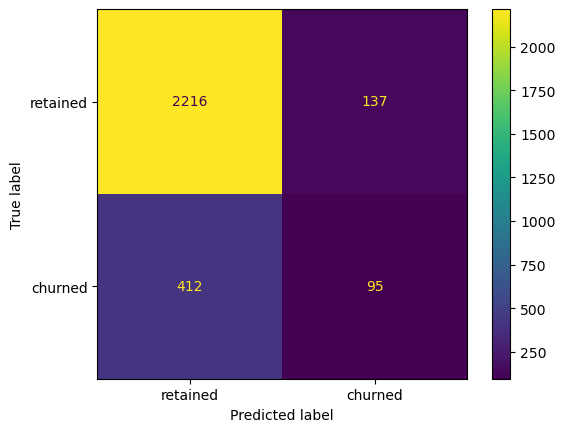

In [38]:
# Generate array of values for confusion matrix
cm = confusion_matrix(y_test, xgb_test_pred, labels=xgb_cv.classes_,)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(cm, display_labels=['retained', 'churned'])
disp.plot()

The model predicted three times as many false negatives than it did false positives, and it correctly identified only 16.6% of the users who actually churned.

### **Task 14. Feature importance**

Use the `plot_importance` function to inspect the most important features of your final model.

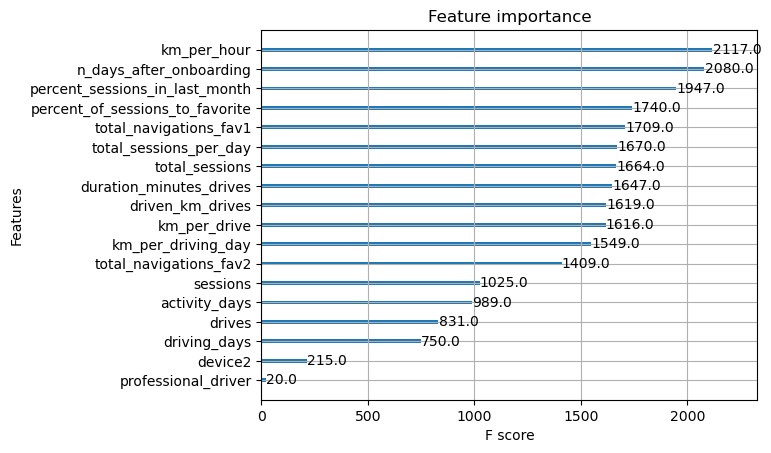

In [39]:
plot_importance(xgb_cv.best_estimator_);

The XGBoost model made more use of many of the features than did the logistic regression model from the previous course, which weighted a single feature (`activity_days`) very heavily in its final prediction.